# JioMart Tier 2/3 Cities Expansion Analysis
## End-to-End Data Science Portfolio Project

---

### Business Context
**JioMart**, the digital commerce arm of Reliance Retail Ventures Ltd., is aggressively scaling operations into non-metro Tier 2 and Tier 3 cities across India, expanding to 5,000+ pin codes and 3,000+ stores.

### Problem Statement
How can JioMart optimize its expansion strategy into Tier 2/3 cities to improve profitability, reduce logistics and inventory costs, and enhance customer retention?

### Hypothesis
Margin erosion and lower repeat purchase rates in Tier 2/3 cities are driven by:
1. Higher logistics and last-mile costs
2. Product assortment mismatch
3. Weaker customer loyalty
4. Insufficient infrastructure leading to spoilage

---

## 1. Import Libraries

In [19]:
# Data Processing
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, silhouette_score, mean_absolute_error, r2_score

# Configuration
np.random.seed(42)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

print("✅ Libraries imported successfully")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

✅ Libraries imported successfully
Pandas version: 2.3.2
NumPy version: 2.0.2


## 2. Load Data

Load the pre-generated datasets from the complete analysis pipeline.

In [20]:
# Load datasets
transactions_df = pd.read_csv('data/transactions.csv')
customers_df = pd.read_csv('data/customers.csv')
stores_df = pd.read_csv('data/stores.csv')
products_df = pd.read_csv('data/products.csv')
inventory_df = pd.read_csv('data/inventory.csv')

print("✅ Data loaded successfully\n")
print(f"Transactions: {len(transactions_df):,} records")
print(f"Customers: {len(customers_df):,} records")
print(f"Stores: {len(stores_df):,} records")
print(f"Products: {len(products_df):,} records")
print(f"Inventory: {len(inventory_df):,} records")

✅ Data loaded successfully

Transactions: 50,000 records
Customers: 15,000 records
Stores: 120 records
Products: 39 records
Inventory: 4,467 records


## 3. Exploratory Data Analysis

### 3.1 Data Overview

In [21]:
# Transaction data overview
print("=" * 80)
print("TRANSACTION DATA OVERVIEW")
print("=" * 80)
transactions_df.head(10)

TRANSACTION DATA OVERVIEW


,transaction_id,transaction_date,customer_id,product_id,store_id,region_tier,quantity,unit_price,revenue,product_cost,logistics_cost,spoilage_cost,total_cost,margin,margin_pct,discount_pct,delivery_time_hours,delivery_distance_km,payment_method,is_perishable
0,TXN0000001,2023-10-21,CUST004488,PRD0012,STR0080,Tier 2,1,44.54,44.54,33.65,52.25,0.36,86.27,-41.73,-93.68,0,3.81,7.79,Wallet,True
1,TXN0000002,2023-10-20,CUST001247,PRD0019,STR0115,Tier 3,3,245.11,735.33,577.56,211.85,0.00,789.41,-54.08,-7.35,0,6.99,39.30,COD,False
2,TXN0000003,2024-05-20,CUST003604,PRD0017,STR0024,Metro,2,76.16,152.32,123.62,21.16,0.00,144.78,7.54,4.95,0,1.10,2.46,Wallet,False
3,TXN0000004,2024-05-17,CUST011418,PRD0002,STR0010,Metro,2,296.01,592.02,474.86,47.25,0.00,522.11,69.91,11.81,0,1.04,12.90,Card,False
4,TXN0000005,2023-12-21,CUST005430,PRD0013,STR0033,Metro,4,176.65,706.61,597.28,22.88,0.00,620.16,86.45,12.23,5,2.78,3.15,Card,False
5,TXN0000006,2024-01-10,CUST012865,PRD0022,STR0025,Metro,3,322.84,968.52,672.75,33.76,0.00,706.51,262.01,27.05,0,1.39,7.50,Card,False
6,TXN0000007,2023-10-25,CUST007562,PRD0037,STR0069,Tier 2,2,1038.19,2076.38,1375.00,55.65,0.00,1430.65,645.73,31.10,0,2.32,8.76,Card,False
7,TXN0000008,2024-01-01,CUST005962,PRD0022,STR0024,Metro,2,306.70,613.40,448.50,43.08,0.00,491.58,121.82,19.86,5,2.67,11.23,Wallet,False
8,TXN0000009,2024-02-13,CUST001166,PRD0028,STR0081,Tier 2,1,58.28,58.28,44.42,69.27,0.00,113.69,-55.41,-95.08,0,4.02,12.65,UPI,False
9,TXN0000010,2024-03-14,CUST010331,PRD0025,STR0107,Tier 3,4,64.74,258.96,212.24,245.92,0.00,458.16,-199.20,-76.92,0,12.69,46.87,COD,False


In [22]:
# Data types and missing values
print("\nData Info:")
print(transactions_df.info())

print("\nMissing Values:")
print(transactions_df.isnull().sum())

print("\nBasic Statistics:")
transactions_df.describe()


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   transaction_id        50000 non-null  object 
 1   transaction_date      50000 non-null  object 
 2   customer_id           50000 non-null  object 
 3   product_id            50000 non-null  object 
 4   store_id              50000 non-null  object 
 5   region_tier           50000 non-null  object 
 6   quantity              50000 non-null  int64  
 7   unit_price            50000 non-null  float64
 8   revenue               50000 non-null  float64
 9   product_cost          50000 non-null  float64
 10  logistics_cost        50000 non-null  float64
 11  spoilage_cost         50000 non-null  float64
 12  total_cost            50000 non-null  float64
 13  margin                50000 non-null  float64
 14  margin_pct            50000 non-null  float64
 15  discoun

,quantity,unit_price,revenue,product_cost,logistics_cost,spoilage_cost,total_cost,margin,margin_pct,discount_pct,delivery_time_hours,delivery_distance_km
count,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000
mean,2.905660,1254.79187,3815.661295,3307.572476,71.206662,0.812046,3379.591183,436.070182,-13.192170,4.412300,3.967935,14.21197
std,2.086894,3082.46816,11874.549672,10765.801726,59.688563,4.510596,10760.309589,1437.643402,59.580972,5.457811,3.364715,11.66527
min,1.000000,35.63000,35.630000,33.650000,17.500000,0.000000,51.150000,-9548.330000,-803.060000,0.000000,0.500000,1.00000
25%,1.000000,118.88000,206.330000,175.200000,33.620000,0.000000,251.840000,-39.472500,-17.920000,0.000000,1.640000,6.36000
50%,2.000000,176.65000,441.200000,353.660000,47.105000,0.000000,441.105000,19.090000,4.600000,5.000000,2.650000,11.05000
75%,4.000000,322.84000,1167.440000,949.720000,91.950000,0.000000,993.667500,179.150000,13.990000,5.000000,5.620000,17.86000
max,10.000000,14730.12000,147301.200000,126645.400000,304.950000,135.660000,126747.730000,20634.840000,43.840000,20.000000,16.000000,59.99000


### 3.2 Regional Performance Analysis

In [23]:
# Regional performance summary
regional_perf = transactions_df.groupby('region_tier').agg({
    'transaction_id': 'count',
    'revenue': 'sum',
    'margin': 'sum',
    'customer_id': 'nunique',
    'delivery_time_hours': 'mean',
    'delivery_distance_km': 'mean',
    'logistics_cost': 'mean',
    'spoilage_cost': 'mean'
}).round(2)

regional_perf.columns = ['Transactions', 'Total Revenue (₹)', 'Total Margin (₹)', 'Unique Customers', 
                          'Avg Delivery Time (hrs)', 'Avg Delivery Distance (km)', 
                          'Avg Logistics Cost (₹)', 'Avg Spoilage Cost (₹)']
regional_perf['Margin %'] = ((regional_perf['Total Margin (₹)'] / regional_perf['Total Revenue (₹)']) * 100).round(2)
regional_perf['Revenue per Customer (₹)'] = (regional_perf['Total Revenue (₹)'] / regional_perf['Unique Customers']).round(2)

print("\n" + "=" * 80)
print("REGIONAL PERFORMANCE SUMMARY")
print("=" * 80)
regional_perf


REGIONAL PERFORMANCE SUMMARY


,Transactions,Total Revenue (₹),Total Margin (₹),Unique Customers,Avg Delivery Time (hrs),Avg Delivery Distance (km),Avg Logistics Cost (₹),Avg Spoilage Cost (₹),Margin %,Revenue per Customer (₹)
region_tier,,,,,,,,,,
Metro,27221,1.361920e+08,18243782.44,7885,1.75,7.99,34.97,0.00,13.40,17272.29
Tier 2,15408,4.557560e+07,3924050.58,4451,5.01,16.49,82.71,1.52,8.61,10239.41
Tier 3,7371,9.015419e+06,-364323.93,2141,9.99,32.44,181.00,2.34,-4.04,4210.84


### 3.3 Visualization: Regional Performance Dashboard

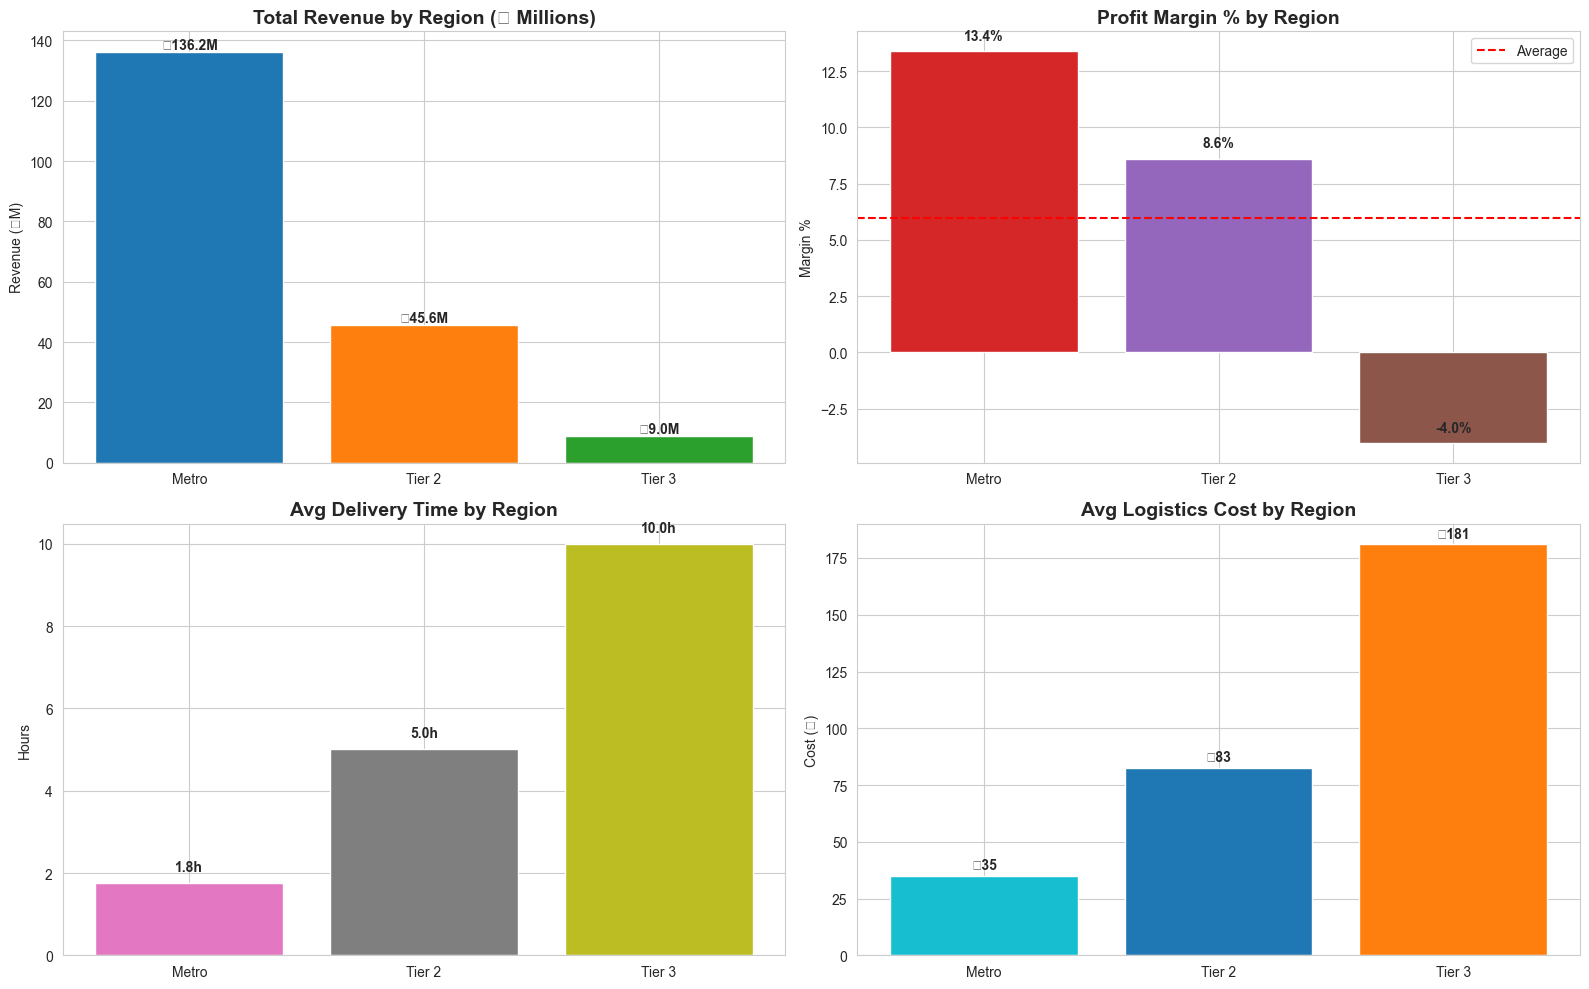

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Revenue by region
revenue_data = regional_perf['Total Revenue (₹)'] / 1_000_000
axes[0, 0].bar(revenue_data.index, revenue_data.values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[0, 0].set_title('Total Revenue by Region (₹ Millions)', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Revenue (₹M)')
for i, v in enumerate(revenue_data.values):
    axes[0, 0].text(i, v + 1, f'₹{v:.1f}M', ha='center', fontweight='bold')

# Margin %
margin_data = regional_perf['Margin %']
axes[0, 1].bar(margin_data.index, margin_data.values, color=['#d62728', '#9467bd', '#8c564b'])
axes[0, 1].set_title('Profit Margin % by Region', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Margin %')
axes[0, 1].axhline(y=margin_data.mean(), color='red', linestyle='--', label='Average')
axes[0, 1].legend()
for i, v in enumerate(margin_data.values):
    axes[0, 1].text(i, v + 0.5, f'{v:.1f}%', ha='center', fontweight='bold')

# Delivery Time
delivery_data = regional_perf['Avg Delivery Time (hrs)']
axes[1, 0].bar(delivery_data.index, delivery_data.values, color=['#e377c2', '#7f7f7f', '#bcbd22'])
axes[1, 0].set_title('Avg Delivery Time by Region', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Hours')
for i, v in enumerate(delivery_data.values):
    axes[1, 0].text(i, v + 0.3, f'{v:.1f}h', ha='center', fontweight='bold')

# Logistics Cost
logistics_data = regional_perf['Avg Logistics Cost (₹)']
axes[1, 1].bar(logistics_data.index, logistics_data.values, color=['#17becf', '#1f77b4', '#ff7f0e'])
axes[1, 1].set_title('Avg Logistics Cost by Region', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Cost (₹)')
for i, v in enumerate(logistics_data.values):
    axes[1, 1].text(i, v + 3, f'₹{v:.0f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

### 3.4 Customer Behavior Analysis

In [25]:
# Customer purchase patterns
customer_behavior = transactions_df.groupby(['customer_id', 'region_tier']).agg({
    'transaction_id': 'count',
    'revenue': 'sum',
    'margin': 'sum'
}).reset_index()
customer_behavior.columns = ['customer_id', 'region_tier', 'purchase_count', 'total_revenue', 'total_margin']

behavior_summary = customer_behavior.groupby('region_tier').agg({
    'purchase_count': 'mean',
    'total_revenue': 'mean',
    'customer_id': 'count'
}).round(2)
behavior_summary.columns = ['Avg Purchases per Customer', 'Avg Revenue per Customer (₹)', 'Total Customers']

# Repeat purchase rate (3+ purchases)
repeat_customers = customer_behavior[customer_behavior['purchase_count'] >= 3].groupby('region_tier').size()
total_customers = customer_behavior.groupby('region_tier').size()
behavior_summary['Repeat Rate (%)'] = ((repeat_customers / total_customers) * 100).round(2)

print("\n" + "=" * 80)
print("CUSTOMER BEHAVIOR SUMMARY")
print("=" * 80)
behavior_summary


CUSTOMER BEHAVIOR SUMMARY


,Avg Purchases per Customer,Avg Revenue per Customer (₹),Total Customers,Repeat Rate (%)
region_tier,,,,
Metro,3.45,17272.29,7885,67.23
Tier 2,3.46,10239.41,4451,67.42
Tier 3,3.44,4210.84,2141,66.42


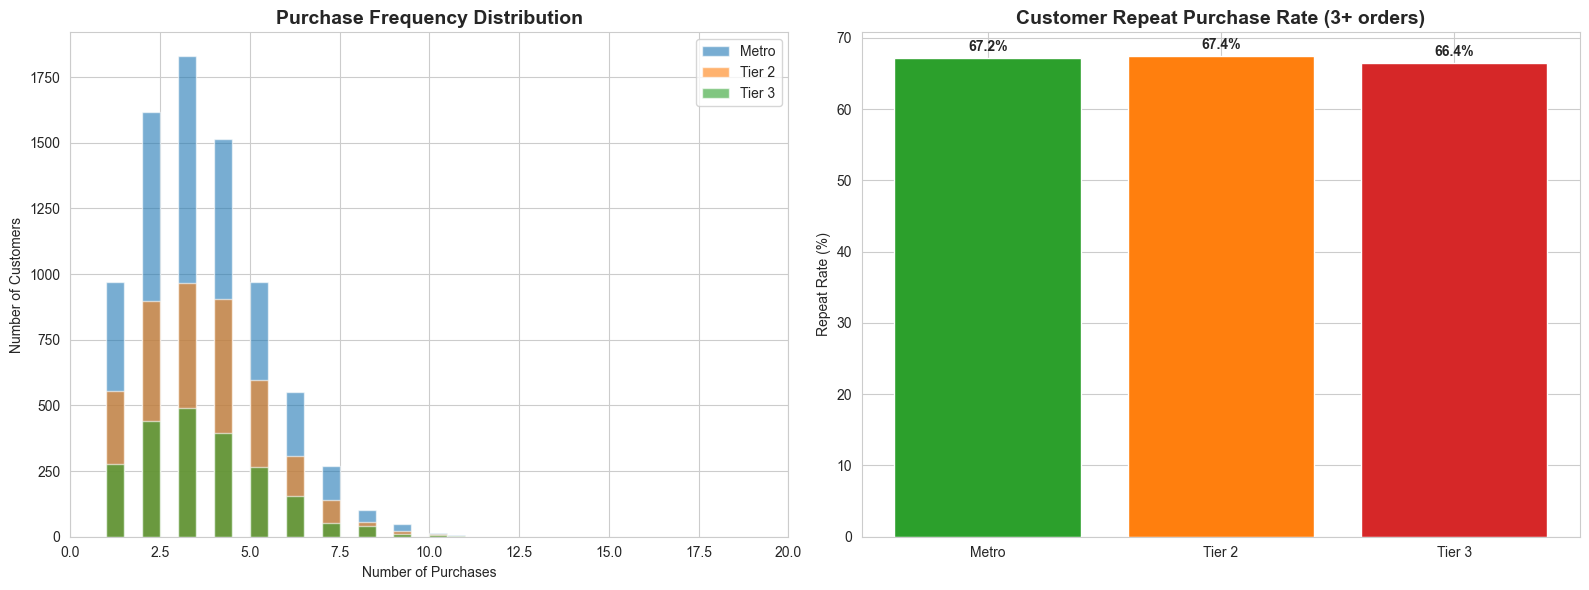

In [26]:
# Visualize customer behavior
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Purchase frequency distribution
for tier in ['Metro', 'Tier 2', 'Tier 3']:
    tier_cust = customer_behavior[customer_behavior['region_tier'] == tier]['purchase_count']
    axes[0].hist(tier_cust, bins=20, alpha=0.6, label=tier)
axes[0].set_title('Purchase Frequency Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Purchases')
axes[0].set_ylabel('Number of Customers')
axes[0].legend()
axes[0].set_xlim(0, 20)

# Repeat rate by region
repeat_rate_data = behavior_summary['Repeat Rate (%)']
axes[1].bar(repeat_rate_data.index, repeat_rate_data.values, color=['#2ca02c', '#ff7f0e', '#d62728'])
axes[1].set_title('Customer Repeat Purchase Rate (3+ orders)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Repeat Rate (%)')
for i, v in enumerate(repeat_rate_data.values):
    axes[1].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

### 3.5 Category Performance Analysis

In [27]:
# Merge with product data
txn_with_product = transactions_df.merge(products_df[['product_id', 'category', 'product_name']], on='product_id')

# Category performance by region
category_perf = txn_with_product.groupby(['region_tier', 'category']).agg({
    'revenue': 'sum',
    'margin': 'sum',
    'transaction_id': 'count'
}).reset_index()
category_perf['margin_pct'] = ((category_perf['margin'] / category_perf['revenue']) * 100).round(2)

print("\n" + "=" * 80)
print("TOP CATEGORIES BY REGION")
print("=" * 80)
category_perf.sort_values(['region_tier', 'revenue'], ascending=[True, False]).head(15)


TOP CATEGORIES BY REGION


,region_tier,category,revenue,margin,transaction_id,margin_pct
0,Metro,Electronics,1.045568e+08,9683712.76,3460,9.26
1,Metro,Fashion,2.019137e+07,6966872.55,3473,34.50
6,Metro,Personal Care,3.980495e+06,849899.39,4298,21.35
3,Metro,Groceries,2.450925e+06,207278.04,4155,8.46
5,Metro,Packaged Foods,1.930732e+06,187385.20,4206,9.71
2,Metro,Fresh Produce,1.664143e+06,188529.66,4196,11.33
4,Metro,Home Care,1.417579e+06,160104.84,3433,11.29
7,Tier 2,Electronics,3.485511e+07,2294402.05,1504,6.58
8,Tier 2,Fashion,5.856143e+06,1803091.59,1472,30.79
13,Tier 2,Personal Care,1.657574e+06,166033.86,2597,10.02


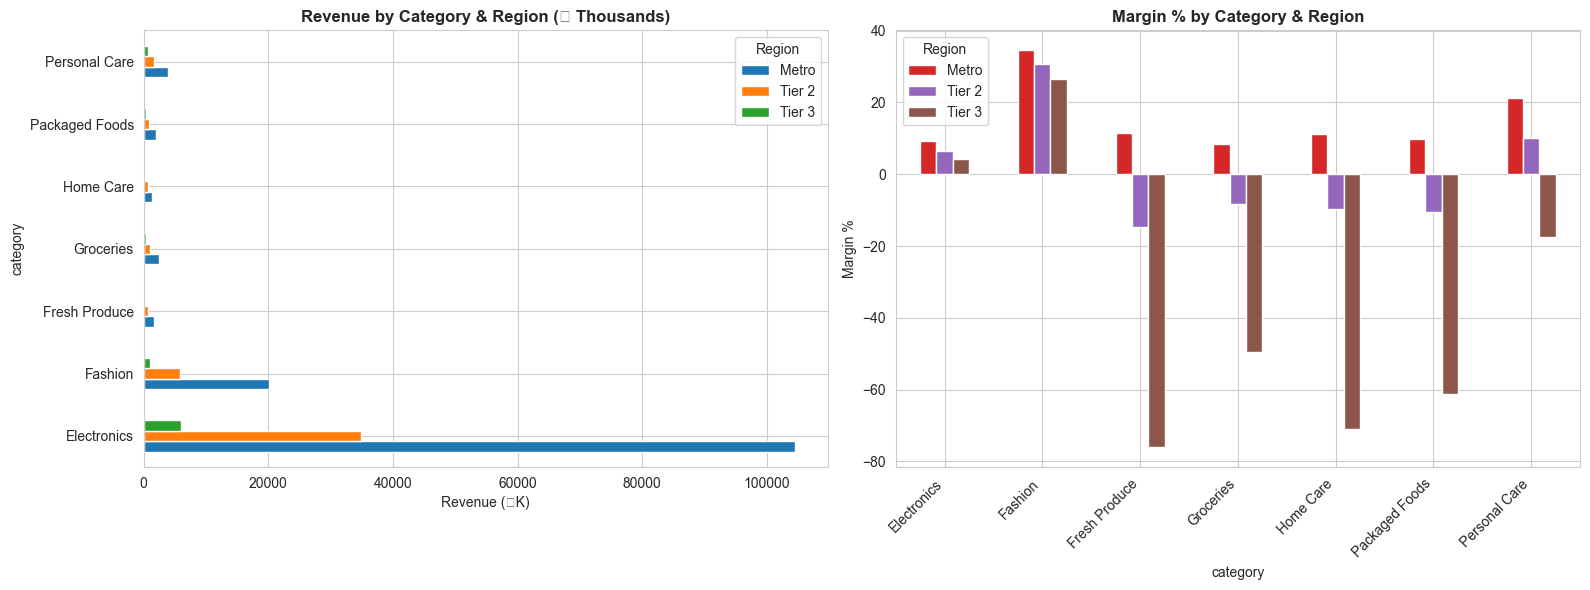

In [28]:
# Visualize category performance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Category revenue by tier
category_revenue = txn_with_product.pivot_table(values='revenue', index='category', columns='region_tier', aggfunc='sum') / 1000
category_revenue.plot(kind='barh', ax=axes[0], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[0].set_title('Revenue by Category & Region (₹ Thousands)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Revenue (₹K)')
axes[0].legend(title='Region')

# Category margin %
category_margins = category_perf.pivot_table(values='margin_pct', index='category', columns='region_tier')
category_margins.plot(kind='bar', ax=axes[1], color=['#d62728', '#9467bd', '#8c564b'])
axes[1].set_title('Margin % by Category & Region', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Margin %')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].legend(title='Region')

plt.tight_layout()
plt.show()

### 3.6 Logistics Analysis

In [29]:
# Cost breakdown by region
logistics_breakdown = transactions_df.groupby('region_tier').agg({
    'product_cost': 'mean',
    'logistics_cost': 'mean',
    'spoilage_cost': 'mean',
    'total_cost': 'mean'
}).round(2)

print("\n" + "=" * 80)
print("COST BREAKDOWN BY REGION")
print("=" * 80)
logistics_breakdown


COST BREAKDOWN BY REGION


,product_cost,logistics_cost,spoilage_cost,total_cost
region_tier,,,,
Metro,4298.02,34.97,0.00,4332.99
Tier 2,2619.02,82.71,1.52,2703.24
Tier 3,1089.19,181.00,2.34,1272.52


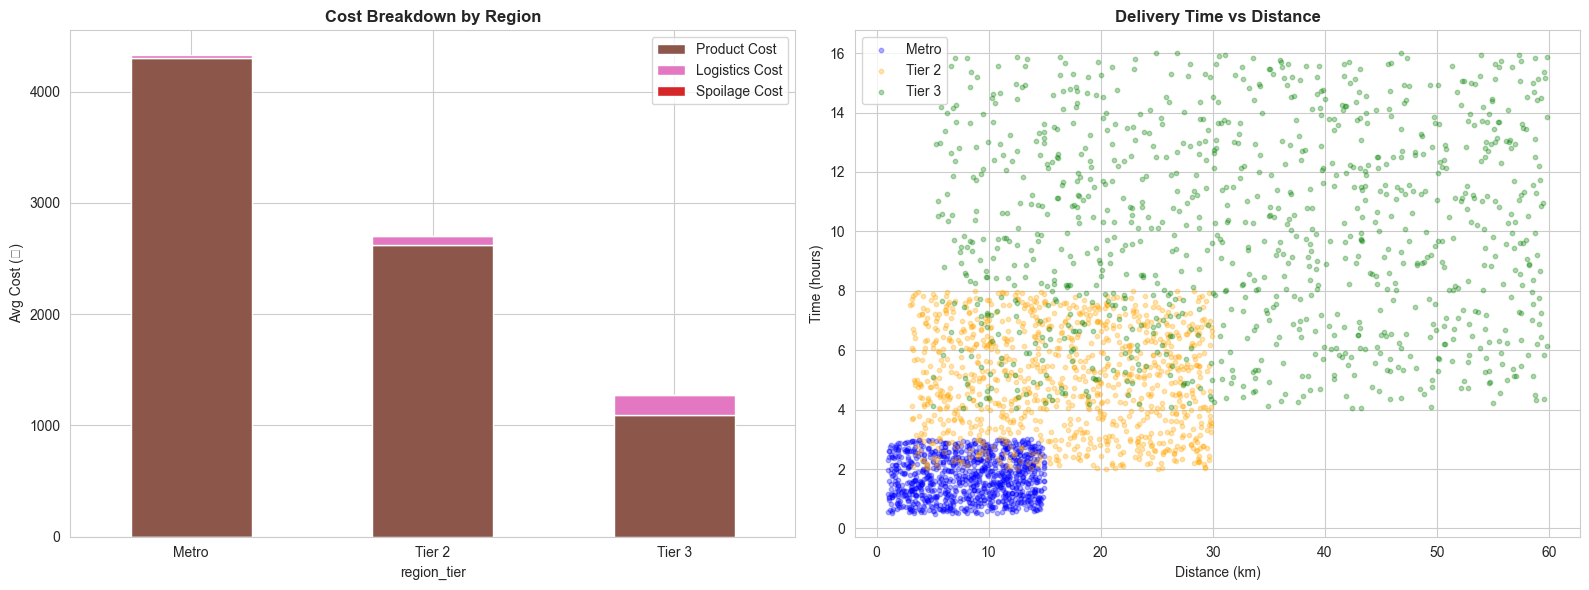

In [30]:
# Visualize logistics analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Cost breakdown
logistics_breakdown[['product_cost', 'logistics_cost', 'spoilage_cost']].plot(
    kind='bar', stacked=True, ax=axes[0], color=['#8c564b', '#e377c2', '#d62728']
)
axes[0].set_title('Cost Breakdown by Region', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Avg Cost (₹)')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].legend(['Product Cost', 'Logistics Cost', 'Spoilage Cost'])

# Delivery time vs distance scatter
for tier, color in [('Metro', 'blue'), ('Tier 2', 'orange'), ('Tier 3', 'green')]:
    data = transactions_df[transactions_df['region_tier'] == tier].sample(min(1000, len(transactions_df[transactions_df['region_tier'] == tier])))
    axes[1].scatter(data['delivery_distance_km'], data['delivery_time_hours'], alpha=0.3, s=10, label=tier, color=color)
axes[1].set_title('Delivery Time vs Distance', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Distance (km)')
axes[1].set_ylabel('Time (hours)')
axes[1].legend()

plt.tight_layout()
plt.show()

## 4. Machine Learning Models

### 4.1 Model 1: Margin Risk Classification

MODEL 1: MARGIN RISK CLASSIFICATION (Random Forest)

High Risk Stores: 107 / 120
Low Risk Stores: 13 / 120

Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.50      0.33      0.40         3
   High Risk       0.93      0.96      0.95        27

    accuracy                           0.90        30
   macro avg       0.71      0.65      0.67        30
weighted avg       0.89      0.90      0.89        30


Top 5 Feature Importances:
                 feature  importance
6  warehouse_distance_km    0.185550
0                revenue    0.175933
1         logistics_cost    0.158529
4          is_perishable    0.155786
3    delivery_time_hours    0.126138


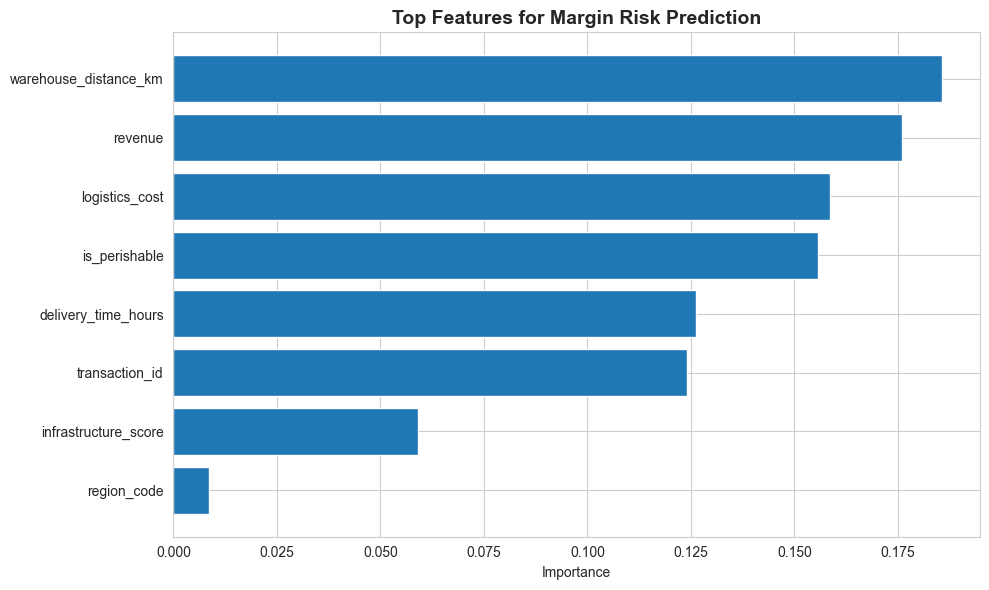

In [31]:
print("=" * 80)
print("MODEL 1: MARGIN RISK CLASSIFICATION (Random Forest)")
print("=" * 80)

# Aggregate store performance
store_perf = transactions_df.groupby('store_id').agg({
    'revenue': 'sum',
    'margin': 'sum',
    'margin_pct': 'mean',
    'logistics_cost': 'mean',
    'spoilage_cost': 'mean',
    'delivery_time_hours': 'mean',
    'is_perishable': 'mean',
    'transaction_id': 'count'
}).reset_index()

store_perf = store_perf.merge(stores_df[['store_id', 'region_tier', 'infrastructure_score', 'warehouse_distance_km']], on='store_id')

# Define high risk: margin % < 10%
store_perf['high_risk'] = (store_perf['margin_pct'] < 10).astype(int)

print(f"\nHigh Risk Stores: {store_perf['high_risk'].sum()} / {len(store_perf)}")
print(f"Low Risk Stores: {(1 - store_perf['high_risk']).sum()} / {len(store_perf)}")

# Prepare features
le = LabelEncoder()
store_perf['region_code'] = le.fit_transform(store_perf['region_tier'])

X = store_perf[['revenue', 'logistics_cost', 'spoilage_cost', 'delivery_time_hours', 
                'is_perishable', 'infrastructure_score', 'warehouse_distance_km', 
                'transaction_id', 'region_code']]
y = store_perf['high_risk']

# Train-test split
if len(y.unique()) > 1:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train Random Forest
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42)
    rf_model.fit(X_train_scaled, y_train)
    
    y_pred = rf_model.predict(X_test_scaled)
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Low Risk', 'High Risk']))
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 5 Feature Importances:")
    print(feature_importance.head())
    
    # Visualize
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['feature'][:8], feature_importance['importance'][:8])
    plt.xlabel('Importance')
    plt.title('Top Features for Margin Risk Prediction', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠ Insufficient class diversity for training")

### 4.2 Model 2: Customer Lifetime Value Prediction

MODEL 2: CUSTOMER LIFETIME VALUE PREDICTION (Gradient Boosting)

Model Performance:
  MAE: ₹13822.00
  R² Score: 0.0685


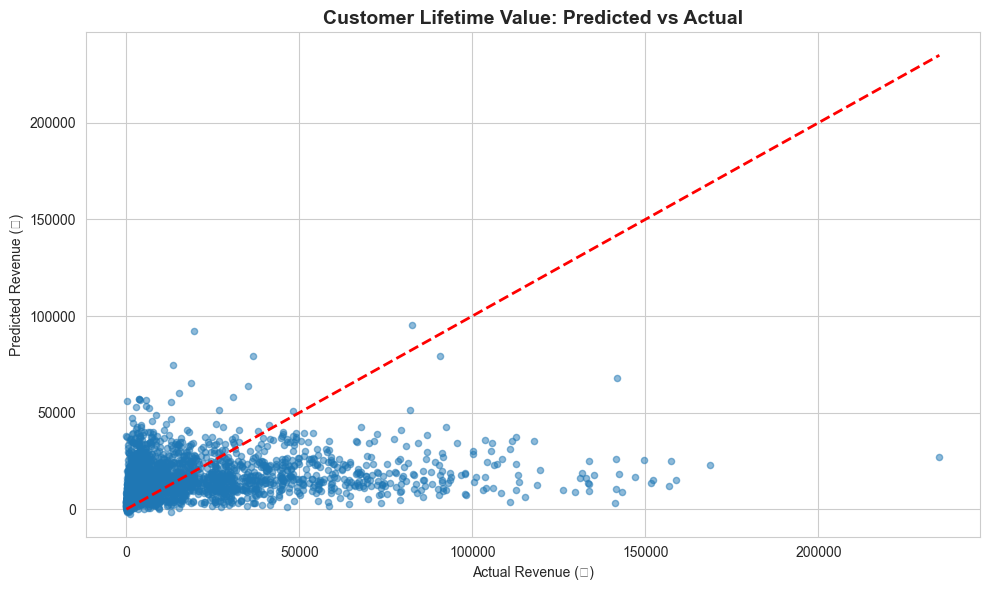

In [32]:
print("=" * 80)
print("MODEL 2: CUSTOMER LIFETIME VALUE PREDICTION (Gradient Boosting)")
print("=" * 80)

# Prepare customer features
cust_features = customer_behavior.merge(customers_df[['customer_id', 'age', 'income_bracket', 
                                                       'digital_literacy_score', 'registration_date']], 
                                        on='customer_id')
cust_features['registration_date'] = pd.to_datetime(cust_features['registration_date'])
cust_features['days_since_registration'] = (datetime(2024, 9, 30) - cust_features['registration_date']).dt.days

# Encode income bracket
income_mapping = {'10-15K': 1, '15-25K': 2, '25-50K': 3, '50-75K': 4, '75K+': 5}
cust_features['income_code'] = cust_features['income_bracket'].map(income_mapping)
cust_features['income_code'] = cust_features['income_code'].fillna(2)  # Default to mid-range

# Features and target
X_clv = cust_features[['purchase_count', 'age', 'income_code', 'digital_literacy_score', 'days_since_registration']]
X_clv['region_code'] = le.transform(cust_features['region_tier'])
y_clv = cust_features['total_revenue']

# Remove any NaN values
mask = ~(X_clv.isna().any(axis=1) | y_clv.isna())
X_clv = X_clv[mask]
y_clv = y_clv[mask]

# Train-test split
X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv, y_clv, test_size=0.25, random_state=42)

# Scale
scaler_clv = StandardScaler()
X_train_clv_scaled = scaler_clv.fit_transform(X_train_clv)
X_test_clv_scaled = scaler_clv.transform(X_test_clv)

# Train Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
gb_model.fit(X_train_clv_scaled, y_train_clv)

y_pred_clv = gb_model.predict(X_test_clv_scaled)

mae = mean_absolute_error(y_test_clv, y_pred_clv)
r2 = r2_score(y_test_clv, y_pred_clv)

print(f"\nModel Performance:")
print(f"  MAE: ₹{mae:.2f}")
print(f"  R² Score: {r2:.4f}")

# Visualize
plt.figure(figsize=(10, 6))
plt.scatter(y_test_clv, y_pred_clv, alpha=0.5, s=20)
plt.plot([y_test_clv.min(), y_test_clv.max()], [y_test_clv.min(), y_test_clv.max()], 'r--', lw=2)
plt.xlabel('Actual Revenue (₹)')
plt.ylabel('Predicted Revenue (₹)')
plt.title('Customer Lifetime Value: Predicted vs Actual', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 4.3 Model 3: Customer Segmentation (K-Means Clustering)

MODEL 3: CUSTOMER SEGMENTATION (K-Means Clustering)

Optimal number of clusters: 2
Best silhouette score: 0.3484

Cluster Profiles:
        purchase_count       total_revenue total_margin    age income_code  \
                 count  mean          mean         mean   mean        mean   
cluster                                                                      
0                 2087  4.62      57114.92      7011.40  32.26        3.86   
1                12390  3.26       5777.58       578.75  33.56        3.18   

        digital_literacy_score  
                          mean  
cluster                         
0                         6.92  
1                         6.22  


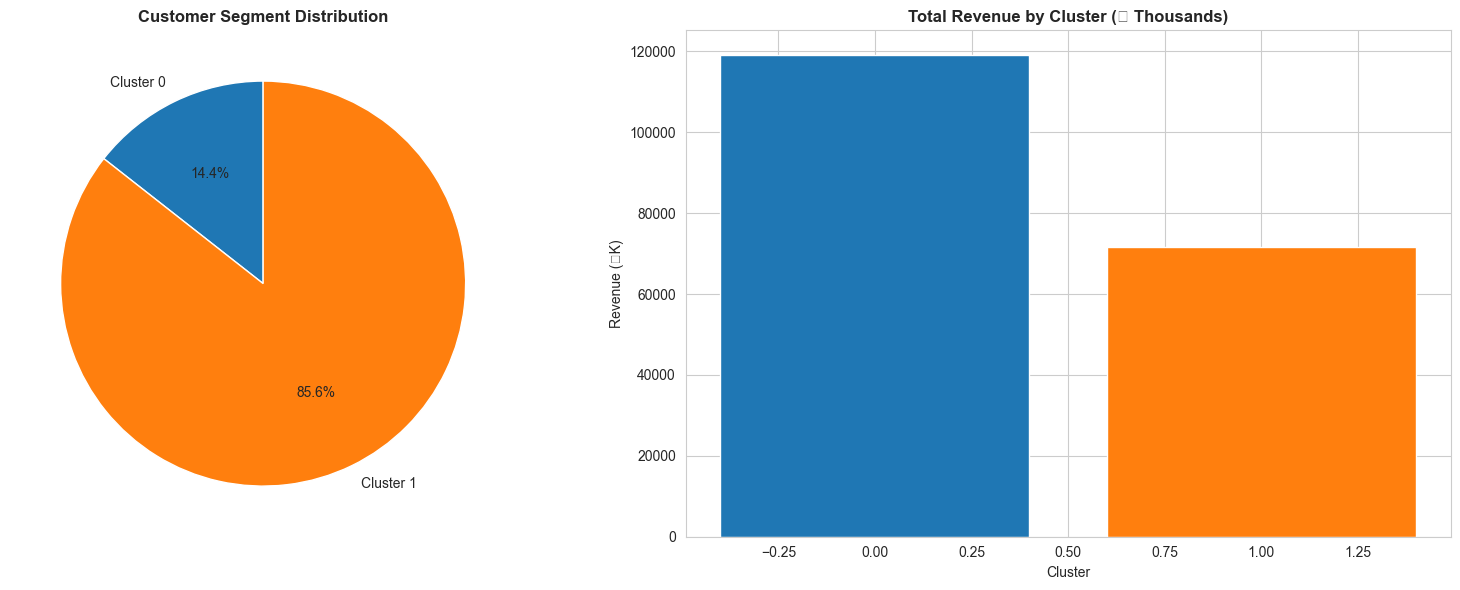

In [33]:
print("=" * 80)
print("MODEL 3: CUSTOMER SEGMENTATION (K-Means Clustering)")
print("=" * 80)

# Prepare clustering features
cluster_data = cust_features[['purchase_count', 'total_revenue', 'total_margin', 
                               'age', 'income_code', 'digital_literacy_score']].copy()

# Remove NaN
cluster_data = cluster_data.dropna()

# Scale for clustering
scaler_cluster = StandardScaler()
cluster_scaled = scaler_cluster.fit_transform(cluster_data)

# Find optimal k using silhouette score
silhouette_scores = []
K_range = range(2, 8)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(cluster_scaled)
    silhouette_scores.append(silhouette_score(cluster_scaled, labels))

optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters: {optimal_k}")
print(f"Best silhouette score: {max(silhouette_scores):.4f}")

# Train final model
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(cluster_scaled)

# Add cluster labels back to original data
cluster_data_with_labels = cluster_data.copy()
cluster_data_with_labels['cluster'] = cluster_labels

# Cluster profiles
cluster_profiles = cluster_data_with_labels.groupby('cluster').agg({
    'purchase_count': ['count', 'mean'],
    'total_revenue': 'mean',
    'total_margin': 'mean',
    'age': 'mean',
    'income_code': 'mean',
    'digital_literacy_score': 'mean'
}).round(2)

print("\nCluster Profiles:")
print(cluster_profiles)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Cluster distribution
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
axes[0].pie(cluster_counts.values, labels=[f'Cluster {i}' for i in cluster_counts.index], 
            autopct='%1.1f%%', startangle=90)
axes[0].set_title('Customer Segment Distribution', fontsize=12, fontweight='bold')

# Revenue by cluster
cluster_revenue = cluster_data_with_labels.groupby('cluster')['total_revenue'].sum() / 1000
axes[1].bar(cluster_revenue.index, cluster_revenue.values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[1].set_title('Total Revenue by Cluster (₹ Thousands)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Revenue (₹K)')
axes[1].set_xlabel('Cluster')

plt.tight_layout()
plt.show()

## 5. Key Insights & Recommendations

### 5.1 Critical Findings

In [34]:
print("=" * 80)
print("KEY BUSINESS INSIGHTS")
print("=" * 80)

# Calculate key insights
metro_margin = regional_perf.loc['Metro', 'Margin %']
tier3_margin = regional_perf.loc['Tier 3', 'Margin %']
margin_gap = metro_margin - tier3_margin

metro_logistics = regional_perf.loc['Metro', 'Avg Logistics Cost (₹)']
tier3_logistics = regional_perf.loc['Tier 3', 'Avg Logistics Cost (₹)']
logistics_increase = ((tier3_logistics - metro_logistics) / metro_logistics) * 100

metro_delivery = regional_perf.loc['Metro', 'Avg Delivery Time (hrs)']
tier3_delivery = regional_perf.loc['Tier 3', 'Avg Delivery Time (hrs)']
time_increase = tier3_delivery - metro_delivery

tier2_customers = regional_perf.loc['Tier 2', 'Unique Customers']
tier3_customers = regional_perf.loc['Tier 3', 'Unique Customers']
total_untapped = tier2_customers + tier3_customers

print(f"\n1. 📊 MARGIN GAP:")
print(f"   Tier 3 cities have {margin_gap:.1f}% lower margins than Metro")
print(f"   Metro: {metro_margin:.2f}% vs Tier 3: {tier3_margin:.2f}%")

print(f"\n2. 🚚 LOGISTICS CHALLENGE:")
print(f"   Tier 3 logistics costs are {logistics_increase:.0f}% higher than Metro")
print(f"   Metro: ₹{metro_logistics:.2f} vs Tier 3: ₹{tier3_logistics:.2f}")

print(f"\n3. ⏱️ DELIVERY DELAY:")
print(f"   Tier 3 deliveries take {time_increase:.1f} hours longer than Metro")
print(f"   Metro: {metro_delivery:.1f}h vs Tier 3: {tier3_delivery:.1f}h")

print(f"\n4. 💰 GROWTH POTENTIAL:")
print(f"   {total_untapped:,.0f} customers in Tier 2/3 represent untapped revenue")
print(f"   Tier 2: {tier2_customers:,.0f} | Tier 3: {tier3_customers:,.0f}")

KEY BUSINESS INSIGHTS

1. 📊 MARGIN GAP:
   Tier 3 cities have 17.4% lower margins than Metro
   Metro: 13.40% vs Tier 3: -4.04%

2. 🚚 LOGISTICS CHALLENGE:
   Tier 3 logistics costs are 418% higher than Metro
   Metro: ₹34.97 vs Tier 3: ₹181.00

3. ⏱️ DELIVERY DELAY:
   Tier 3 deliveries take 8.2 hours longer than Metro
   Metro: 1.8h vs Tier 3: 10.0h

4. 💰 GROWTH POTENTIAL:
   6,592 customers in Tier 2/3 represent untapped revenue
   Tier 2: 4,451 | Tier 3: 2,141


### 5.2 Strategic Recommendations

In [35]:
print("\n" + "=" * 80)
print("STRATEGIC RECOMMENDATIONS")
print("=" * 80)

recommendations = {
    "1. Optimize Last-Mile Logistics": [
        "• Establish micro-fulfillment centers in Tier 2/3 city clusters",
        "• Partner with local logistics providers familiar with regional terrain",
        "• Implement hub-and-spoke distribution model"
    ],
    "2. Improve Inventory Management": [
        "• Deploy predictive analytics for demand forecasting",
        "• Reduce perishable inventory in Tier 3 stores initially",
        "• Implement FIFO strictly for fresh produce"
    ],
    "3. Tailor Product Assortment": [
        "• Focus on non-perishables for Tier 3 (Groceries, Home Care)",
        "• Gradually introduce premium products based on digital literacy",
        "• Create region-specific bundles"
    ],
    "4. Enhance Customer Retention": [
        "• Launch loyalty programs with tier-based rewards",
        "• Offer free delivery for repeat customers in Tier 2/3",
        "• Use targeted WhatsApp marketing"
    ],
    "5. Technology Deployment": [
        "• Deploy route optimization software",
        "• Implement IoT sensors for cold chain monitoring",
        "• Use AI chatbots for customer support"
    ]
}

for key, actions in recommendations.items():
    print(f"\n{key}:")
    for action in actions:
        print(f"  {action}")


STRATEGIC RECOMMENDATIONS

1. Optimize Last-Mile Logistics:
  • Establish micro-fulfillment centers in Tier 2/3 city clusters
  • Partner with local logistics providers familiar with regional terrain
  • Implement hub-and-spoke distribution model

2. Improve Inventory Management:
  • Deploy predictive analytics for demand forecasting
  • Reduce perishable inventory in Tier 3 stores initially
  • Implement FIFO strictly for fresh produce

3. Tailor Product Assortment:
  • Focus on non-perishables for Tier 3 (Groceries, Home Care)
  • Gradually introduce premium products based on digital literacy
  • Create region-specific bundles

4. Enhance Customer Retention:
  • Launch loyalty programs with tier-based rewards
  • Offer free delivery for repeat customers in Tier 2/3
  • Use targeted WhatsApp marketing

5. Technology Deployment:
  • Deploy route optimization software
  • Implement IoT sensors for cold chain monitoring
  • Use AI chatbots for customer support


## 6. Summary & Conclusion

In [36]:
print("\n" + "=" * 80)
print("PROJECT SUMMARY")
print("=" * 80)

print(f"\n📊 Key Metrics:")
print(f"  • Total Transactions: {len(transactions_df):,}")
print(f"  • Total Revenue: ₹{transactions_df['revenue'].sum()/1_000_000:.2f}M")
print(f"  • Total Margin: ₹{transactions_df['margin'].sum()/1_000_000:.2f}M")
print(f"  • Unique Customers: {transactions_df['customer_id'].nunique():,}")
print(f"  • Active Stores: {len(stores_df)}")
print(f"  • Product SKUs: {len(products_df)}")

print(f"\n🎯 Models Trained:")
print(f"  1. Random Forest - Margin Risk Classification")
print(f"  2. Gradient Boosting - Customer Lifetime Value Prediction")
print(f"  3. K-Means Clustering - Customer Segmentation")

print(f"\n✅ Analysis Complete!")
print("=" * 80)


PROJECT SUMMARY

📊 Key Metrics:
  • Total Transactions: 50,000
  • Total Revenue: ₹190.78M
  • Total Margin: ₹21.80M
  • Unique Customers: 14,477
  • Active Stores: 120
  • Product SKUs: 39

🎯 Models Trained:
  1. Random Forest - Margin Risk Classification
  2. Gradient Boosting - Customer Lifetime Value Prediction
  3. K-Means Clustering - Customer Segmentation

✅ Analysis Complete!


---

## End of Analysis

**Project:** JioMart Tier 2/3 Cities Expansion Analysis  
**Author:** Data Science Portfolio  
**Date:** October 2024

This notebook demonstrates end-to-end data science capabilities including:
- Data analysis and exploration
- Statistical insights and business intelligence
- Machine learning model development
- Visualization and storytelling
- Strategic recommendation generation

---